# Setup

In [ ]:
# Mount data
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Files' location, set to your object-detection-zoo-master repository
%cd '/content/drive/My Drive/object-detection-zoo-masterr/'

/content/drive/My Drive/object-detection-zoo-masterr


In [ ]:
#Run this cell when starting a new kernel
# This cell can be commented out after running once

# Set up virtual environment
!pip install virtualenv
!virtualenv -p /usr/bin/python3 bigdata
!source bigdata/bin/activate

# Fix bugs and install dependencies
!pip uninstall -y tensorflow
!pip install -r requirements.txt


In [ ]:
# In case tensorflow bugs are experienced
# Try to unintall and install tensorflow-gpu 

!pip uninstall tensorflow-gpu==1.14.0
!pip install tensorflow-gpu==1.14.0

In [ ]:
from general_utils.processing import letterbox_image_padded, decode_detection_raw
from general_utils.visualization import visualize_detection

import json
import cv2
import time
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

In [ ]:
# Load video
vidcap = cv2.VideoCapture('president-on-tech-green.mov')

In [ ]:
# Functions

def getFrame(sec):
  vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
  hasFrames,img = vidcap.read()
  return (img, hasFrames)

def generateCv2img(cv2img, detection_processed, path = None, display = False):
  fontScale = 0.7 # font & text block ratio
  for box in detection_processed:
    id, label, conf = box[0], box[1], box[2]
    x1, y1, x2, y2 = box[3], box[4], box[5], box[6]
    cv2.rectangle(cv2img,(x1,y1),(x2,y2),(0,255,0),6)

    labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,fontScale,2)
    _x1 = x1
    _y1 = y1
    _x2 = _x1 + int(labelSize[0][0] * fontScale)
    _y2 = y1 - int(labelSize[0][1]* fontScale)
    cv2.rectangle(cv2img,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
    cv2.putText(cv2img,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)

  if path != None:
    cv2.imwrite(path + str(count) + ".jpg", cv2img)

  if display: 
    cv2_imshow(cv2img)

  return cv2img

  cv2.destroyAllWindows()

##Methods to Decrease Prediction Time


In [ ]:

#Method1

#calculate the average cumulative prediction time and compare it with the target fps to fluctuate to a different fps 

def changePredTime(goal, changeTo, times, fps_list):

  avg_time=sum(times)/len(times)
  
  #changing framerate according to prediction time average so far
  if avg_time > (1/24) :
    frame_rate= changeTo
  else:
    frame_rate= goal

  fps_list.append(frame_rate)

  return frame_rate

#Method2

#if prediction time at n-1 increased since n-2 , fluctuate to a different fps; if prediction time at n-1 is decreased since n-2, keep the target fps

def changePredTime2(goal, changeTo, times, fps_list, count):

  if (times[count-1]-times[count-2]) >= 0:
    frame_rate= changeTo
  else:
    frame_rate= goal

  fps_list.append(frame_rate)

  return frame_rate

##SSD 512

In [ ]:

from detectors.ssd import SSD512
# Load the model
detector = SSD512(weights='model_weights/SSD_VOC0712_VGG16_512x512.h5')

# Parameters
sec = 0
fps = 24
frameRate = 1 / fps # interval between frames
goal=1/24
changeTo=1/10     #one of the values from [1/5, 1/10, 1/15, 1/20] can be selected as changeTo variable value
count = 0
success = getFrame(sec)
images = []
cv2imgs = []
times = []
results = []
result_imgs = []
fps_list=[]
fps_list.append(frameRate)
modelName = "ssd512"
path = './output/'+ modelName + str(fps) + '/'

# Convert the video to frames and make prediction
while success:
  count = count + 1
  sec = sec + frameRate
  sec = round(sec, 2)
  image ,success = getFrame(sec)
  
  if not success:
    continue

  # convert np array back to image
  cv2img = image
  cv2imgs.append(image)
  image = Image.fromarray(image) 
  images.append(image)

  # Time and make prediction
  x_query, x_meta = letterbox_image_padded(image, size=detector.model_img_size)
  start = time.time()
  detection_raw = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
  end = time.time()
  detection_processed = decode_detection_raw(detection_raw, x_meta, detector.classes)
  
  # Generate and save the result image
  result_img = generateCv2img(cv2img, detection_processed, path = path, display = False)
  result_imgs.append(result_img)

  # Collect the result
  results.append(detection_processed)
  times.append(end - start)

  #method1
  #changing fps if there is lag
  # frameRate=changePredTime(goal, changeTo, times, fps_list)

  #method2
  #changing fps if there is lag
  if len(times)>1:
    frameRate=changePredTime2(goal, changeTo, times, fps_list, count) 


print("Number of frames:", len(times))

# Time summary    
summary = [max(times), min(times), sum(times)/len(times) ]
print("Prediction time list", times)
print("Max:", max(times))
print("Min:", min(times))
print("Avg:", sum(times)/len(times))

# Save intervals 
# data = json.dumps(times)

# with open(path + 'intervals.json', 'w') as f:
#     json.dump(data, f)
# # Save summary
# data = json.dumps(summary)
# with open(path + 'time_summary.json', 'w') as f:
#     json.dump(data, f)

  
# Confidence summary
conf = []
for elm in results:
  if len(elm) != 0:
    conf.append(elm[0][2])

confFps = {}
confFps['rawConfList'] = conf
confFps['maxConf'] = max(conf)
confFps['minConf'] = min(conf)
confFps['avgConf'] = sum(conf)/len(conf)
print('max(conf)', confFps['maxConf'])
print('min(conf)', confFps['minConf'])
print('avgConf', confFps['avgConf'])

Number of frames: 203
Prediction time list [3.5265321731567383, 0.09258460998535156, 0.09012651443481445, 0.08404064178466797, 0.08269977569580078, 0.08277368545532227, 0.08382129669189453, 0.08334708213806152, 0.08368396759033203, 0.08211874961853027, 0.08346009254455566, 0.08264875411987305, 0.08364534378051758, 0.08861112594604492, 0.09002256393432617, 0.09222912788391113, 0.09005308151245117, 0.09163904190063477, 0.09028434753417969, 0.09075355529785156, 0.09170103073120117, 0.09322690963745117, 0.09029293060302734, 0.08924412727355957, 0.08888626098632812, 0.08457612991333008, 0.0778651237487793, 0.0753788948059082, 0.07410144805908203, 0.07584762573242188, 0.0741426944732666, 0.0755307674407959, 0.075286865234375, 0.07704496383666992, 0.07666563987731934, 0.07336544990539551, 0.0760805606842041, 0.08231186866760254, 0.08559346199035645, 0.09135627746582031, 0.0842442512512207, 0.0870361328125, 0.0922539234161377, 0.09212589263916016, 0.09306645393371582, 0.0921163558959961, 0.091

In [ ]:
import pandas as pd
#Results of using only 24 fps
fps_24 = pd.DataFrame(
    # {'FPS': fps_list,
     {'Times24': times,
     'Confidence24': conf 
    })
fps_24

,Times24,Confidence24
0,2.941921,0.999936
1,0.092501,0.999542
2,0.100120,0.999648
3,0.092705,0.999727
4,0.089655,0.999118
...,...,...
198,0.092422,0.999885
199,0.090070,0.999883
200,0.079166,0.999881
201,0.077438,0.999816


In [ ]:

#Results of using both 20 and 24 fps
import pandas as pd
fps_2420 = pd.DataFrame(
    {'FPS2420': fps_list,
     'Times2420': times,
     'Confidence2420': conf 
    })
fps_2420

,FPS2420,Times2420,Confidence2420
0,0.000000,1.931087,0.999936
1,0.041667,0.091071,0.999542
2,0.050000,0.091203,0.999648
3,0.041667,0.085222,0.999359
4,0.041667,0.079201,0.999118
...,...,...,...
174,0.041667,0.071980,0.999885
175,0.050000,0.073601,0.999883
176,0.041667,0.072655,0.999887
177,0.050000,0.074306,0.999818


In [ ]:
#Results of using both 24 and 15
fps_list.insert(0,0)
fps_2415 = pd.DataFrame(
    {'FPS2415': fps_list,
     'Times2415': times,
     'Confidence2415': conf 
    })
fps_2415

,FPS2415,Times2415,Confidence2415
0,0.000000,2.100381,0.999936
1,0.041667,0.090249,0.999542
2,0.041667,0.085165,0.999648
3,0.041667,0.076473,0.999727
4,0.041667,0.076252,0.999118
...,...,...,...
144,0.066667,0.085923,0.999888
145,0.041667,0.085473,0.999883
146,0.041667,0.085310,0.999881
147,0.041667,0.081389,0.999816


In [ ]:
#Results of using both 24 and 10
fps_list.insert(0,0)
fps_2410 = pd.DataFrame(
    {'FPS2410': fps_list,
     'Times2410': times,
     'Confidence2410': conf 
    })
fps_2410

,FPS2410,Times2410,Confidence2410
0,0.000000,2.343856,0.999936
1,0.041667,0.090586,0.999542
2,0.041667,0.090225,0.999648
3,0.041667,0.081773,0.999727
4,0.041667,0.081131,0.999118
...,...,...,...
117,0.100000,0.083866,0.999389
118,0.100000,0.086388,0.999624
119,0.100000,0.088527,0.999883
120,0.041667,0.086212,0.999816


In [ ]:
#Results of using both 24 and 5
fps_list.insert(0,0)
fps_2405 = pd.DataFrame(
    {'FPS2405': fps_list,
     'Times2405': times,
     'Confidence2405': conf 
    })
fps_2405

,FPS2405,Times2405,Confidence2405
0,0.000000,2.604544,0.999936
1,0.041667,0.091049,0.999542
2,0.041667,0.090880,0.999648
3,0.041667,0.080118,0.999727
4,0.200000,0.083033,0.999118
...,...,...,...
64,0.200000,0.099676,0.999850
65,0.041667,0.085413,0.999834
66,0.041667,0.077057,0.999885
67,0.041667,0.074663,0.999883


In [ ]:
fps_2415.to_excel('2415method2.xlsx')
fps_2405.to_excel('2405method2.xlsx')
fps_2410.to_excel('2410method2.xlsx')
fps_2420.to_excel('2420method2.xlsx')
fps_24.to_excel('24method2.xlsx')

In [ ]:
#only 24 fps
import matplotlib.pyplot as plt
plt.plot(fps_2405[1:].Times2405)  #5
plt.plot(fps_2410.iloc[1:].Times2410)
plt.plot(fps_2415.iloc[1:].Times2415)
plt.plot(fps_2420.iloc[1:].Times2420)
plt.plot(fps_24.iloc[1:].Times24)

plt.title('Prediction Times') 

plt.legend(["5", "10","15", "20","24"],loc='center left', bbox_to_anchor=(1.0, 0.5))


# plt.ylabel('some numbers')
plt.show()

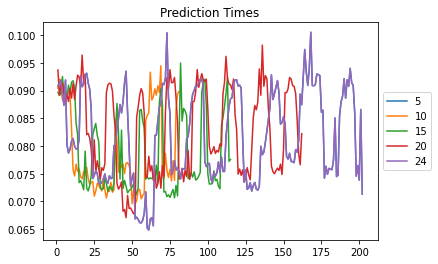

In [ ]:
#only 24 fps
#method1 
import matplotlib.pyplot as plt

plt.plot(fps_2405[1:].Times2405)  
plt.plot(fps_2410.iloc[1:].Times2410)
plt.plot(fps_2415.iloc[1:].Times2415)
plt.plot(fps_2420.iloc[1:].Times2420)
plt.plot(fps_24.iloc[1:].Times24)

plt.title('Prediction Times') 

plt.legend(["5", "10","15", "20","24"],loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

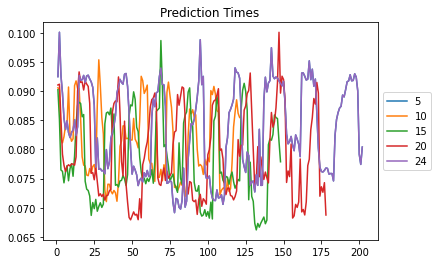

In [ ]:
#method2
import matplotlib.pyplot as plt

plt.plot(fps_2405[1:].Times2405)  
plt.plot(fps_2410.iloc[1:].Times2410)
plt.plot(fps_2415.iloc[1:].Times2415)
plt.plot(fps_2420.iloc[1:].Times2420)
plt.plot(fps_24and20.iloc[1:].Times24)

plt.title('Prediction Times') 

plt.legend(["5", "10","15", "20","24"],loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [ ]:
#cumulative avg for only 24 fps 
def hello2(new_g):
  for i in range(len(new_g.index)):
    if i==0 or i==1:
      new_g.loc[i,"new"]=new_g.iloc[i,0]
    else:
      new_g.loc[i,"new"]=(new_g.iloc[i,0]+new_g.loc[i-1,"new"])/i
  return new_g

In [ ]:
#cumulative avg for the rest
def hello(new_g):
  for i in range(len(new_g.index)):
    if i==0 or i==1:
      new_g.loc[i,"new"]=new_g.iloc[i,1]
    else:
      new_g.loc[i,"new"]=(new_g.iloc[i,1]+new_g.loc[i-1,"new"])/i
  return new_g

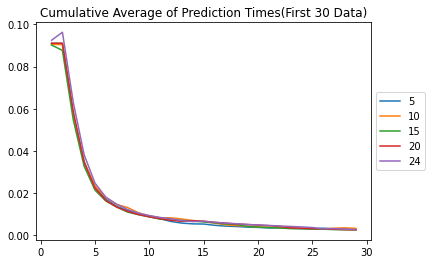

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hello(fps_2405).iloc[1:30].new)  
plt.plot(hello(fps_2410).iloc[1:30].new)
plt.plot(hello(fps_2415).iloc[1:30].new)
plt.plot(hello(fps_2420).iloc[1:30].new)
plt.plot(hello2(fps_24and20).iloc[1:30].new)

plt.title('Cumulative Average of Prediction Times(First 30 Data)') 


plt.legend(["5", "10","15", "20","24"],loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()